In [92]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from multi_imbalance.resampling.spider import SPIDER3
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from multi_imbalance.datasets import load_datasets
from multi_imbalance.resampling.MDO import MDO
from multi_imbalance.resampling.SOUP import SOUP
from collections import Counter
from imblearn.metrics import geometric_mean_score
from IPython.core.display import display
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from multi_imbalance.resampling.GlobalCS import GlobalCS
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from multi_imbalance.utils.array_util import union

In [2]:
def read_train_and_test_data(overlap, imbalance_ratio, i):
    with open(f"data/3class-{imbalance_ratio}-overlap-{overlap}-learn-{i}.arff") as f:
        content = f.readlines()
    content = [x.strip().split(",") for x in content][5:]
    data = np.array(content)
    X_train, y_train = data[:, :-1].astype(float), data[:, -1].astype(object)

    with open(f"data/3class-{imbalance_ratio}-overlap-{overlap}-test-{i}.arff") as f:
        content = f.readlines()
    content = [x.strip().split(",") for x in content][5:]
    data = np.array(content)
    X_test, y_test = data[:, :-1].astype(float), data[:, -1].astype(object)

    return X_train, y_train, X_test, y_test


def train_and_test():
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    labels = ['MIN', 'INT', 'MAJ']
    return [confusion_matrix(y_test, y_pred, labels=labels)[i, i] / confusion_matrix(y_test, y_pred, labels=labels)[i,:].sum() for i,label in enumerate(labels)]


In [ ]:
# cost = np.reshape(np.array([0, 2, 3, 3, 0, 2, 7, 5, 0]), (3, 3))
# cost = np.reshape(np.array([0, 3, 7, 2, 0, 5, 3, 2, 0]), (3, 3))
# cost = np.reshape(np.array([0, 1, 1, 3, 0, 1, 7, 5, 0]), (3, 3)) # odkopana
# cost = np.reshape(np.array([0, 1, 1, 2, 0, 1, 6, 3, 0]), (3, 3)) # try 1
# cost = np.reshape(np.array([0, 2, 6, 1, 0, 3, 1, 1, 0]), (3, 3)) # try 1
# cost = np.reshape(np.array([0, 1, 1, 1, 0, 1, 1, 1, 0]), (3, 3))


In [20]:
cost_matrix = np.array([[0,1,1],[3,0,1],[7,5,0]])

result = []


for imbalance_ratio in ["70-30-0-0", "40-50-10-0", "30-40-15-15"]:
    print(f"Imbalance ratio: {imbalance_ratio}")
    for overlap in range(0, 3):
        print(f"Overlap: {overlap}")
        for setting in ['base', 'default', 'article']:
            min_tpr = []
            int_tpr = []
            maj_tpr = []
            for i in range(1,11):
                X_train, y_train, X_test, y_test = read_train_and_test_data(overlap, imbalance_ratio, i)
                if setting == 'base':
                    pass
                elif setting == 'default':
                    cost = np.ones((3, 3))
                    for i in range(3):
                        cost[i][i] = 0

                    clf = SPIDER3(k=5, majority_classes=['MAJ'],
                                  intermediate_classes=['INT'], minority_classes=['MIN'], cost=cost)
                    X_train, y_train = clf.fit_transform(X_train.astype(np.float64), y_train)
                elif setting == 'article':
                    clf = SPIDER3(k=5, majority_classes=['MAJ'],
                                  intermediate_classes=['INT'], minority_classes=['MIN'], cost=cost_matrix)
                    X_train, y_train = clf.fit_transform(X_train.astype(np.float64), y_train)
                min_t, int_t, maj_t = train_and_test()
                min_tpr.append(min_t)
                int_tpr.append(int_t)
                maj_tpr.append(maj_t)
            print(setting, [np.array(min_tpr).mean(), np.array(int_tpr).mean(), np.array(maj_tpr).mean()])
            result.append([np.array(min_tpr).mean(), np.array(int_tpr).mean(), np.array(maj_tpr).mean()])
np.savetxt("article_results.csv", np.asarray(result), delimiter=",")

Imbalance ratio: 70-30-0-0
Overlap: 0
base [0.772, 0.8379999999999999, 0.9133333333333333]
default [0.922, 0.9640000000000001, 0.882]
article [0.9719999999999999, 0.992, 0.8556666666666667]
Overlap: 1
base [0.638, 0.792, 0.9286666666666665]
default [0.758, 0.906, 0.9013333333333335]
article [0.788, 0.922, 0.8803333333333334]
Overlap: 2
base [0.434, 0.6809999999999999, 0.9329999999999998]
default [0.532, 0.766, 0.9129999999999999]
article [0.5520000000000002, 0.779, 0.898]
Imbalance ratio: 40-50-10-0
Overlap: 0
base [0.6739999999999999, 0.7689999999999999, 0.8633333333333333]
default [0.89, 0.961, 0.76]
article [0.9319999999999998, 0.969, 0.748]
Overlap: 1
base [0.568, 0.7299999999999999, 0.8780000000000001]
default [0.74, 0.898, 0.7903333333333333]
article [0.766, 0.907, 0.7776666666666667]
Overlap: 2
base [0.45600000000000007, 0.702, 0.8953333333333333]
default [0.656, 0.8379999999999999, 0.8103333333333333]
article [0.6639999999999999, 0.843, 0.8020000000000002]
Imbalance ratio: 30-4

In [21]:
pd.read_csv("article_results.csv", header=None)

,0,1,2
0,0.772,0.838,0.913333
1,0.922,0.964,0.882000
2,0.972,0.992,0.855667
3,0.638,0.792,0.928667
4,0.758,0.906,0.901333
5,0.788,0.922,0.880333
6,0.434,0.681,0.933000
7,0.532,0.766,0.913000
8,0.552,0.779,0.898000
9,0.674,0.769,0.863333


In [5]:
result = []


for imbalance_ratio in ["70-30-0-0", "40-50-10-0", "30-40-15-15"]:
    print(f"Imbalance ratio: {imbalance_ratio}")
    for overlap in range(0, 3):
        print(f"Overlap: {overlap}")
        for setting in ['base', 'default', 'custom']:
            min_tpr = []
            int_tpr = []
            maj_tpr = []
            for i in range(1,11):
                X_train, y_train, X_test, y_test = read_train_and_test_data(overlap, imbalance_ratio, i)
                if setting == 'base':
                    pass
                elif setting == 'default':
                    cost = np.ones((3, 3))
                    for i in range(3):
                        cost[i][i] = 0

                    clf = SPIDER3(k=5, majority_classes=['MAJ'],
                                  intermediate_classes=['INT'], minority_classes=['MIN'], cost=cost)
                    X_train, y_train = clf.fit_transform(X_train.astype(np.float64), y_train)
                elif setting == 'custom':
                    clf = SPIDER3(k=5, majority_classes=['MAJ'],
                                  intermediate_classes=['INT'], minority_classes=['MIN'])
                    X_train, y_train = clf.fit_transform(X_train.astype(np.float64), y_train)
                min_t, int_t, maj_t = train_and_test()
                min_tpr.append(min_t)
                int_tpr.append(int_t)
                maj_tpr.append(maj_t)
            print(setting, [np.array(min_tpr).mean(), np.array(int_tpr).mean(), np.array(maj_tpr).mean()])
            result.append([np.array(min_tpr).mean(), np.array(int_tpr).mean(), np.array(maj_tpr).mean()])
np.savetxt("spider-results.csv", np.asarray(result), delimiter=",")

Imbalance ratio: 70-30-0-0
Overlap: 0
base [0.772, 0.8379999999999999, 0.9133333333333333]
default [0.922, 0.9640000000000001, 0.882]
custom [0.97, 0.9710000000000001, 0.8666666666666666]
Overlap: 1
base [0.638, 0.792, 0.9286666666666665]
default [0.758, 0.906, 0.9013333333333335]
custom [0.788, 0.9030000000000001, 0.8936666666666667]
Overlap: 2
base [0.434, 0.6809999999999999, 0.9329999999999998]
default [0.532, 0.766, 0.9129999999999999]
custom [0.55, 0.7699999999999999, 0.9056666666666666]
Imbalance ratio: 40-50-10-0
Overlap: 0
base [0.6739999999999999, 0.7689999999999999, 0.8633333333333333]
default [0.89, 0.961, 0.76]
custom [0.9319999999999998, 0.9450000000000001, 0.7576666666666666]
Overlap: 1
base [0.568, 0.7299999999999999, 0.8780000000000001]
default [0.74, 0.898, 0.7903333333333333]
custom [0.768, 0.897, 0.7863333333333333]
Overlap: 2
base [0.45600000000000007, 0.702, 0.8953333333333333]
default [0.656, 0.8379999999999999, 0.8103333333333333]
custom [0.6639999999999999, 0.83

In [8]:
df = pd.read_csv("spider-results.csv", header=None)

### Experiments on synthetic dataset

In [9]:
df

,0,1,2
0,0.772,0.838,0.913333
1,0.922,0.964,0.882000
2,0.970,0.971,0.866667
3,0.638,0.792,0.928667
4,0.758,0.906,0.901333
5,0.788,0.903,0.893667
6,0.434,0.681,0.933000
7,0.532,0.766,0.913000
8,0.550,0.770,0.905667
9,0.674,0.769,0.863333


In [2]:
datasets = load_datasets()

In [3]:
datasets.keys()

odict_keys(['1czysty-cut', '2delikatne-cut', '3mocniej-cut', '4delikatne-bezover-cut', 'balance-scale', 'cleveland', 'cleveland_v2', 'cmc', 'dermatology', 'glass', 'hayes-roth', 'new_ecoli', 'new_led7digit', 'new_vehicle', 'new_winequality-red', 'new_yeast', 'thyroid-newthyroid'])

In [4]:
for k in datasets.keys():
    print(k, Counter(datasets[k].target))

1czysty-cut Counter({0: 840, 2: 240, 1: 120})
2delikatne-cut Counter({0: 840, 2: 240, 1: 120})
3mocniej-cut Counter({0: 840, 2: 240, 1: 120})
4delikatne-bezover-cut Counter({0: 840, 2: 240, 1: 120})
balance-scale Counter({2: 288, 1: 288, 0: 49})
cleveland Counter({0: 164, 1: 55, 2: 36, 3: 35, 4: 13})
cleveland_v2 Counter({0: 219, 1: 36, 2: 35, 3: 13})
cmc Counter({0: 629, 2: 511, 1: 333})
dermatology Counter({0: 112, 2: 72, 1: 61, 4: 52, 3: 49, 5: 20})
glass Counter({1: 76, 0: 70, 3: 29, 5: 17, 2: 13, 4: 9})
hayes-roth Counter({0: 65, 1: 64, 2: 31})
new_ecoli Counter({0: 145, 1: 77, 4: 52, 2: 37, 3: 25})
new_led7digit Counter({3: 108, 5: 99, 0: 98, 2: 94, 4: 52, 1: 49})
new_vehicle Counter({1: 429, 0: 218, 2: 199})
new_winequality-red Counter({0: 681, 1: 638, 2: 199, 3: 81})
new_yeast Counter({0: 463, 1: 429, 8: 244, 7: 168, 6: 51, 5: 44, 4: 35, 3: 30, 2: 20})
thyroid-newthyroid Counter({0: 150, 1: 35, 2: 30})


In [3]:
maj_int_min = {
    "1czysty-cut": {'maj': [0], 'int': [2], 'min': [1]},
    "2delikatne-cut": {'maj': [0], 'int': [2], 'min': [1]},
    "3mocniej-cut": {'maj': [0], 'int': [2], 'min': [1]},
    "4delikatne-bezover-cut": {'maj': [0], 'int': [2], 'min': [1]},
    "balance-scale": {'maj': [2, 1], 'int': [], 'min': [0]},
    "cleveland": {'maj': [0], 'int': [], 'min': [1, 2, 3, 4]},
    "cleveland_v2": {'maj': [0], 'int': [], 'min': [1, 2, 3]},
    "cmc": {'maj': [0, 2], 'int': [], 'min': [1]},
    "dermatology": {'maj': [0, 2, 1, 4, 3], 'int': [], 'min': [5]},
    "glass": {'maj': [1, 0, 3], 'int': [], 'min': [5, 2, 4]},
    "hayes-roth": {'maj': [0, 1], 'int': [], 'min': [2]},
    "new_ecoli": {'maj': [0, 1], 'int': [], 'min': [4, 2, 3]},
    "new_led7digit": {'maj': [3, 5, 0, 2], 'int': [], 'min': [4, 1]},
    "new_vehicle": {'maj': [1], 'int': [], 'min': [0, 2]},
    "new_winequality-red": {'maj': [0, 1], 'int': [], 'min': [2, 3]},
    "new_yeast": {'maj': [0, 1, 8, 7], 'int': [], 'min': [6, 5, 4, 3, 2]},
    "thyroid-newthyroid": {'maj': [0], 'int': [], 'min': [1, 2]}
}

In [11]:
def calc_cost_matrix(dataset_name, cost_strategy):
    if cost_strategy == 'default':
        #default
        no_classes = np.unique(datasets[dataset_name].target).size
        cost = np.ones((no_classes, no_classes))
        np.fill_diagonal(cost, 0)
        return cost
    elif cost_strategy == 'custom_1':
        return SPIDER3._estimate_cost_matrix(datasets[dataset_name].target)
    elif cost_strategy == 'custom_2':
    return cost

In [12]:
def test(cost_strategy):
    np.random.seed(0)

    datasets = load_datasets()
    results_g_mean = dict()
    results_acc = dict()

    for dataset_name, dataset_values in datasets.items():
        #if dataset_name == 'dermatology' or dataset_name == 'new_ecoli':
        #    continue
        print(dataset_name)

        X, y = dataset_values.data, dataset_values.target

        #if len(X)>1000:
        #    continue

        results_g_mean[dataset_name]=dict()
        results_acc[dataset_name]=dict()

        for resample in ['base','global', 'soup', 'mdo', 'spider']:

            skf = StratifiedKFold(n_splits=5, random_state=0)
            acc, g_mean = list(),list()
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                error_flag = False
                clf_tree = DecisionTreeClassifier(random_state=0)

                if resample == 'base':
                    X_train_resampled, y_train_resampled = X_train, y_train
                elif resample=='soup':
                    soup = SOUP()
                    X_train_resampled, y_train_resampled = soup.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='global':
                    global_cs = GlobalCS()
                    X_train_resampled, y_train_resampled = global_cs.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='smote':
                    try:
                        smote = SMOTE()
                        X_train_resampled, y_train_resampled = smote.fit_sample(np.copy(X_train), np.copy(y_train))
                    except Exception as e:
                        error_flag = True
                        print(resample, dataset_name, e)
                        X_train_resampled, y_train_resampled = X_train, y_train
                elif resample=='mdo':
                    mdo = MDO(k=9, k1_frac=0, seed=0)
                    X_train_resampled, y_train_resampled = mdo.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='spider':
                    cost = calc_cost_matrix(dataset_name, cost_strategy)
                    clf = SPIDER3(k=5, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'], cost=cost)
                    X_train_resampled, y_train_resampled = clf.fit_transform(X_train.astype(np.float64), y_train)

                clf_tree.fit(X_train_resampled, y_train_resampled)
                y_pred = clf_tree.predict(X_test)
                g_mean.append(geometric_mean_score(y_test, y_pred, correction=0.001))
                acc.append(accuracy_score(y_test, y_pred))

            result_g_mean = None if error_flag else round(np.mean(g_mean),3)
            result_acc = None if error_flag else round(np.mean(acc),3)

            results_g_mean[dataset_name][resample]=result_g_mean
            results_acc[dataset_name][resample]=result_acc

    display("G-MEAN")
    df = pd.DataFrame(results_g_mean).T
    display(df)

    display("MEAN G-MEAN")
    df.fillna(df.median(), inplace=True)
    display(df.mean())

In [6]:
test(cost_strategy='default')

1czysty-cut
2delikatne-cut
3mocniej-cut
4delikatne-bezover-cut
balance-scale
cleveland
cleveland_v2
cmc
dermatology
glass
hayes-roth
new_ecoli
new_led7digit
new_vehicle
new_winequality-red
new_yeast
thyroid-newthyroid


'G-MEAN'

,base,global,soup,mdo,spider
1czysty-cut,0.937,0.946,0.951,0.966,0.954
2delikatne-cut,0.651,0.676,0.771,0.716,0.727
3mocniej-cut,0.404,0.445,0.543,0.489,0.500
4delikatne-bezover-cut,0.723,0.752,0.874,0.796,0.845
balance-scale,0.247,0.103,0.266,0.192,0.378
cleveland,0.120,0.086,0.116,0.057,0.142
cleveland_v2,0.063,0.054,0.262,0.099,0.175
cmc,0.447,0.450,0.459,0.433,0.418
dermatology,0.905,0.912,0.920,0.955,0.905
glass,0.495,0.721,0.658,0.538,0.601


'ACC'

,base,global,soup,mdo,spider
1czysty-cut,0.958,0.962,0.938,0.961,0.962
2delikatne-cut,0.822,0.832,0.804,0.825,0.822
3mocniej-cut,0.680,0.701,0.632,0.627,0.616
4delikatne-bezover-cut,0.842,0.852,0.828,0.841,0.849
balance-scale,0.619,0.552,0.563,0.625,0.533
cleveland,0.466,0.508,0.386,0.459,0.443
cleveland_v2,0.644,0.653,0.581,0.627,0.585
cmc,0.479,0.473,0.472,0.462,0.431
dermatology,0.915,0.917,0.911,0.951,0.932
glass,0.707,0.692,0.594,0.655,0.568


'MEAN G-MEAN'

base      0.564118
global    0.563118
soup      0.618882
mdo       0.591000
spider    0.582647
dtype: float64

'MEAN ACC'

base      0.727000
global    0.721118
soup      0.683941
mdo       0.717000
spider    0.664882
dtype: float64

In [13]:
test(cost_strategy='custom_1')

1czysty-cut
2delikatne-cut
3mocniej-cut
4delikatne-bezover-cut
balance-scale
cleveland
cleveland_v2
cmc
dermatology
glass
hayes-roth
new_ecoli
new_led7digit
new_vehicle
new_winequality-red
new_yeast
thyroid-newthyroid


'G-MEAN'

,base,global,soup,mdo,spider
1czysty-cut,0.937,0.946,0.951,0.966,0.951
2delikatne-cut,0.651,0.676,0.771,0.716,0.758
3mocniej-cut,0.404,0.445,0.543,0.489,0.518
4delikatne-bezover-cut,0.723,0.752,0.874,0.796,0.853
balance-scale,0.247,0.103,0.266,0.192,0.371
cleveland,0.120,0.086,0.116,0.057,0.068
cleveland_v2,0.063,0.054,0.262,0.099,0.082
cmc,0.447,0.450,0.459,0.433,0.447
dermatology,0.905,0.912,0.920,0.955,0.912
glass,0.495,0.721,0.658,0.538,0.552


'MEAN G-MEAN'

base      0.564118
global    0.563118
soup      0.618882
mdo       0.591000
spider    0.567294
dtype: float64

In [31]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: bold'
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [17]:
def calc_cost_matrix(dataset_name, cost_strategy):
    if cost_strategy == 'default':
        #default
        no_classes = np.unique(datasets[dataset_name].target).size
        cost = np.ones((no_classes, no_classes))
        np.fill_diagonal(cost, 0)
        return cost
    elif cost_strategy == 'custom_1': # IR pod diagonala, wyzej jedynki
        return SPIDER3._estimate_cost_matrix(datasets[dataset_name].target)
    elif cost_strategy == 'custom_2': # odwrotnie, tj IR nad diagonala, nizej jedynki
        y=datasets[dataset_name].target
        class_cardinality = Counter(y)
        classes = list(class_cardinality.keys())
        cost = np.ones([len(classes), len(classes)])
        for i, (c1, card1) in enumerate(class_cardinality.items()):
            for j, (c2, card2) in enumerate(class_cardinality.items()):
                if j < i:
                    cost[i, j] = 1
                else:
                    cost[i, j] = card1 / card2
        np.fill_diagonal(cost, 0)
    elif cost_strategy == 'custom_3': # IR wszedzie
        y=datasets[dataset_name].target
        class_cardinality = Counter(y)
        classes = list(class_cardinality.keys())
        cost = np.ones([len(classes), len(classes)])
        for i, (c1, card1) in enumerate(class_cardinality.items()):
            for j, (c2, card2) in enumerate(class_cardinality.items()):
                cost[i, j] = card1 / card2
        np.fill_diagonal(cost, 0)
    return cost

In [94]:
def test_spiders(options):
    np.random.seed(0)

    datasets = load_datasets()
    results_g_mean = dict()
    results_acc = dict()

    for dataset_name, dataset_values in datasets.items():
        #if dataset_name == 'dermatology' or dataset_name == 'new_ecoli':
        #    continue
        print(dataset_name)

        X, y = dataset_values.data, dataset_values.target

        #if len(X)>1000:
        #    continue

        results_g_mean[dataset_name]=dict()
        results_acc[dataset_name]=dict()

        for resample in options:

            skf = StratifiedKFold(n_splits=5, random_state=0)
            acc, g_mean, acc2, g_mean2 = list(),list(), [], []
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                error_flag = False
                clf_tree = DecisionTreeClassifier(random_state=0)

                if resample == 'base':
                    X_train_resampled, y_train_resampled = X_train, y_train
                elif resample == 'xgboost':
                    model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
                    model.fit(X_train, y_train)
                    cm = confusion_matrix(y_test, model.predict(X_test))
                    cost = cm.T
                    cost[cost == 0] = 1
                    np.fill_diagonal(cost, 0)
                    clf = SPIDER3(k=5, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'], cost=cost)
                    X_train_resampled, y_train_resampled = clf.fit_transform(X_train.astype(np.float64), y_train)
                else:
                    cost = calc_cost_matrix(dataset_name, resample)
                    clf = SPIDER3(k=5, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'], cost=cost)
                    X_train_resampled, y_train_resampled = clf.fit_transform(X_train.astype(np.float64), y_train)
                    
                clf_tree.fit(X_train_resampled, y_train_resampled)
                y_pred = clf_tree.predict(X_test)
                g_mean.append(geometric_mean_score(y_test, y_pred, correction=0.001))
                acc.append(accuracy_score(y_test, y_pred))
                
                neigh = KNeighborsClassifier(n_neighbors=1)
                for i in range(0, 2):
                    std = union(X_train,X_test)[:,i].std()
                    if std == 0:
                        std = 1e-6
                    mean = union(X_train,X_test)[:,i].mean()
                    X_train_resampled[:, i] = (X_train_resampled[:, i] - mean) / (4 * std)
                    X_test[:, i] = (X_test[:, i] - mean) / (4 * std)
                neigh.fit(X_train_resampled, y_train_resampled)
                y_pred = neigh.predict(X_test)
                g_mean2.append(geometric_mean_score(y_test, y_pred, correction=0.001))
                acc2.append(accuracy_score(y_test, y_pred))

            result_g_mean = None if error_flag else round(np.mean(g_mean),3)
            result_acc = None if error_flag else round(np.mean(acc),3)
            result_g_mean2 = None if error_flag else round(np.mean(g_mean2),3)
            result_acc2 = None if error_flag else round(np.mean(acc2),3)

            results_g_mean[dataset_name][resample + " tree"]=result_g_mean
            results_acc[dataset_name][resample + " tree"]=result_acc
            results_g_mean[dataset_name][resample + " knn"]=result_g_mean2
            results_acc[dataset_name][resample + " knn"]=result_acc2

    display("G-MEAN")
    df = pd.DataFrame(results_g_mean).T
    display(df.style.apply(highlight_max, axis=1))

    display("MEAN G-MEAN")
    df.fillna(df.median(), inplace=True)
    display(df.mean())
    return df

In [33]:
spdrs = test_spiders()

1czysty-cut
2delikatne-cut
3mocniej-cut
4delikatne-bezover-cut
balance-scale
cleveland
cleveland_v2
cmc
dermatology
glass
hayes-roth
new_ecoli
new_led7digit
new_vehicle
new_winequality-red
new_yeast
thyroid-newthyroid


'G-MEAN'

,base,default,custom_1,custom_2,custom_3
1czysty-cut,0.937,0.954,0.951,0.951,0.947
2delikatne-cut,0.651,0.727,0.758,0.758,0.752
3mocniej-cut,0.404,0.5,0.518,0.519,0.511
4delikatne-bezover-cut,0.723,0.845,0.853,0.853,0.842
balance-scale,0.247,0.378,0.371,0.318,0.304
cleveland,0.12,0.142,0.068,0.164,0.052
cleveland_v2,0.063,0.175,0.082,0.226,0.216
cmc,0.447,0.418,0.447,0.444,0.433
dermatology,0.905,0.905,0.912,0.912,0.909
glass,0.495,0.601,0.552,0.44,0.47


'MEAN G-MEAN'

base        0.564118
default     0.582647
custom_1    0.567294
custom_2    0.570706
custom_3    0.555412
dtype: float64

In [55]:
def visualize_dataset(dataset):
    pca = PCA(n_components=2)
    n = len(Counter(dataset.target).keys())
    p = sns.color_palette("husl", n)
    pca.fit(dataset.data)
    X = pca.transform(dataset.data)
    y = dataset.target
    df = construct_flat_2pc_df(X,y)
    sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, legend='full', palette=p)

Counter({0: 65, 1: 64, 2: 31})


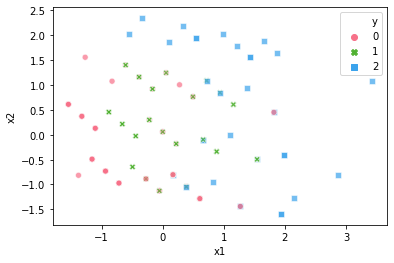

In [56]:
# take XGBoost and see where it makes mistakes

import xgboost as xgb
from multi_imbalance.utils.data import construct_flat_2pc_df
hayes = datasets['hayes-roth']
visualize_dataset(hayes)
print(Counter(hayes.target))
X_train, X_test, y_train, y_test = train_test_split(hayes.data, hayes.target, test_size=0.33, random_state=42)

In [85]:
model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
model.fit(X_train, y_train)
cm = confusion_matrix(y_test, model.predict(X_test))
costs = cm.T
np.fill_diagonal(costs, 0)
costs

array([[0, 3, 1],
       [8, 0, 0],
       [0, 0, 0]], dtype=int64)

In [86]:
Counter(y_test)

Counter({1: 20, 2: 11, 0: 22})

In [87]:
costs[costs == 0] = 1

In [88]:
np.fill_diagonal(costs, 0)
costs

array([[0, 3, 1],
       [8, 0, 1],
       [1, 1, 0]], dtype=int64)

In [95]:
another = test_spiders(['base', 'xgboost'])

1czysty-cut
2delikatne-cut
3mocniej-cut
4delikatne-bezover-cut
balance-scale
cleveland
cleveland_v2
cmc
dermatology
glass
hayes-roth
new_ecoli
new_led7digit
new_vehicle
new_winequality-red
new_yeast
thyroid-newthyroid


'G-MEAN'

,base tree,base knn,xgboost tree,xgboost knn
1czysty-cut,0.937,0.963,0.952,0.973
2delikatne-cut,0.651,0.658,0.76,0.768
3mocniej-cut,0.404,0.401,0.497,0.494
4delikatne-bezover-cut,0.723,0.73,0.867,0.866
balance-scale,0.247,0.271,0.247,0.402
cleveland,0.12,0.116,0.156,0.156
cleveland_v2,0.063,0.114,0.094,0.235
cmc,0.447,0.432,0.416,0.4
dermatology,0.905,0.858,0.905,0.875
glass,0.495,0.534,0.577,0.538


'MEAN G-MEAN'

base tree       0.564118
base knn        0.551000
xgboost tree    0.570471
xgboost knn     0.582059
dtype: float64

In [96]:
another = test_spiders(['base', 'default', 'custom_1', 'custom_2', 'custom_3', 'xgboost'])

1czysty-cut
2delikatne-cut
3mocniej-cut
4delikatne-bezover-cut
balance-scale
cleveland
cleveland_v2
cmc
dermatology
glass
hayes-roth
new_ecoli
new_led7digit
new_vehicle
new_winequality-red
new_yeast
thyroid-newthyroid


'G-MEAN'

,base tree,base knn,default tree,default knn,custom_1 tree,custom_1 knn,custom_2 tree,custom_2 knn,custom_3 tree,custom_3 knn,xgboost tree,xgboost knn
1czysty-cut,0.937,0.963,0.954,0.968,0.951,0.971,0.951,0.971,0.947,0.97,0.952,0.973
2delikatne-cut,0.651,0.658,0.727,0.737,0.758,0.751,0.758,0.751,0.752,0.748,0.76,0.768
3mocniej-cut,0.404,0.401,0.5,0.465,0.518,0.474,0.519,0.474,0.511,0.473,0.497,0.494
4delikatne-bezover-cut,0.723,0.73,0.845,0.837,0.853,0.832,0.853,0.832,0.842,0.838,0.867,0.866
balance-scale,0.247,0.271,0.378,0.514,0.371,0.515,0.318,0.507,0.304,0.497,0.247,0.402
cleveland,0.12,0.116,0.142,0.16,0.068,0.148,0.164,0.148,0.052,0.148,0.156,0.156
cleveland_v2,0.063,0.114,0.175,0.182,0.082,0.179,0.226,0.131,0.216,0.179,0.094,0.235
cmc,0.447,0.432,0.418,0.42,0.447,0.413,0.444,0.416,0.433,0.405,0.416,0.4
dermatology,0.905,0.858,0.905,0.875,0.912,0.869,0.912,0.869,0.909,0.864,0.905,0.875
glass,0.495,0.534,0.601,0.558,0.552,0.616,0.44,0.613,0.47,0.609,0.577,0.538


'MEAN G-MEAN'

base tree        0.564118
base knn         0.551000
default tree     0.582647
default knn      0.583588
custom_1 tree    0.567294
custom_1 knn     0.583941
custom_2 tree    0.570706
custom_2 knn     0.582353
custom_3 tree    0.555412
custom_3 knn     0.578647
xgboost tree     0.570471
xgboost knn      0.582059
dtype: float64